In [1]:
# !pip uninstall rdsutils --yes
# !pip install -i https://repository.sofi.com/artifactory/api/pypi/pypi/simple rdsutils --no-cache-dir

In [214]:
import pandas as pd
import numpy as np
import pickle as pkl
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Data
---

In [3]:
modeling_df = pd.read_parquet('../../artifacts/20201005/modeling_df_w_baseline_preds.parquet')
test_df = pd.read_parquet('../../artifacts/20201005/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 214), (88890, 207))

In [4]:
features = pkl.load(open('../../artifacts/20201005/features_corr_removed.pkl', 'rb'))
features

['vantage_score',
 'first_deposit_amount',
 'bcc7120',
 'credit_card_loan_amount',
 'plaid_max_avail_bal',
 'total_tradelines_open',
 'plaid_days_since_first_link',
 'nr_transactions_30d_div_nr_past_transactions',
 'plaid_min_avail_bal',
 'nr_transactions_per_day',
 'max_deposits_10d_div_mean_account_balance_30d',
 'fico_score',
 'sum_deposits_10d',
 'quovo_largest_checking_or_savings_balance',
 'total_outstanding_balance',
 'rolling_trns_as_pct_of_bal',
 'phone_risk_score',
 'quovo_available_bal',
 'email_risk_score',
 'deposits_ratio',
 'fraud_score_1',
 'mean_deposits_10d_div_mean_deposits',
 'fraud_score_2',
 'nr_past_deposits',
 'quovo_min_avail_bal',
 'address_risk_score']

In [403]:
len(features)

26

### Cleaning...
---
- [ ] clipping
- [ ] fillna
- [ ] encoding if needed

In [5]:
modeling_df.head()

,user_id,business_account_number,transaction_datetime,transaction_code,is_return,transaction_amount,endbal,external_account_number,real_ending_balance,external_institution_id,...,dollar_val_returns,dollar_val_returns_3d,transaction_date,account_ending_balance,days_since_first_transaction,ach_target,deposit_v1_pred,deposit_v1_updated_pred,boruta_pred_1005,customer_pred
10224161,2739821,410000070632,2020-05-19 18:01:26,ACHDD,False,88.0,610.73,101434249,35259.43,031176110,...,0.0,4.440892e-16,2020-05-19,35259.43,847.0,False,0.004101,0.055297,0.042219,0.000916
9871303,3599351,410000070641,2020-05-08 18:01:05,ACHDD,False,120.0,620.09,3533131722724,6439.15,124085244,...,120.0,0.000000e+00,2020-05-08,6439.15,785.0,False,0.094721,0.113542,0.058251,0.004485
10332885,3599351,410000070641,2020-05-22 18:01:05,ACHDD,False,120.0,386.81,3533131722724,6472.36,124085244,...,120.0,0.000000e+00,2020-05-22,6472.36,799.0,False,0.087164,0.113542,0.067546,0.006790
10818509,3599351,410000070641,2020-06-04 18:01:06,ACHDD,False,120.0,506.89,3533131722724,6592.44,124085244,...,120.0,0.000000e+00,2020-06-04,6592.44,812.0,False,0.087164,0.113542,0.060686,0.005704
11383098,3599351,410000070641,2020-06-19 18:01:26,ACHDD,False,120.0,620.00,3533131722724,6712.44,124085244,...,120.0,0.000000e+00,2020-06-19,6712.44,827.0,False,0.087164,0.113542,0.060686,0.005113


In [6]:
df = modeling_df[features].copy()

In [7]:
df.columns

Index(['vantage_score', 'first_deposit_amount', 'bcc7120',
       'credit_card_loan_amount', 'plaid_max_avail_bal',
       'total_tradelines_open', 'plaid_days_since_first_link',
       'nr_transactions_30d_div_nr_past_transactions', 'plaid_min_avail_bal',
       'nr_transactions_per_day',
       'max_deposits_10d_div_mean_account_balance_30d', 'fico_score',
       'sum_deposits_10d', 'quovo_largest_checking_or_savings_balance',
       'total_outstanding_balance', 'rolling_trns_as_pct_of_bal',
       'phone_risk_score', 'quovo_available_bal', 'email_risk_score',
       'deposits_ratio', 'fraud_score_1',
       'mean_deposits_10d_div_mean_deposits', 'fraud_score_2',
       'nr_past_deposits', 'quovo_min_avail_bal', 'address_risk_score'],
      dtype='object')

### Generate Report on Features
---

In [174]:
df = modeling_df[features].copy()

In [9]:
import pandas_profiling

profile = pandas_profiling.ProfileReport(modeling_df[features], 
                                         explorative=True, 
                                         dark_mode=True, 
                                         config_file='pandas_profiling_config.yaml')
profile.to_file('../../artifacts/20201005/feature_report.html', silent=True)

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


### Encoding Workstation
---

In [384]:
from rdsutils.data_wrangling import DataWrangler
dw = DataWrangler()

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'fico_score': [pd.Interval(0, 850), True]
}

In [385]:
df = modeling_df[features].copy()

address_risk_score 26


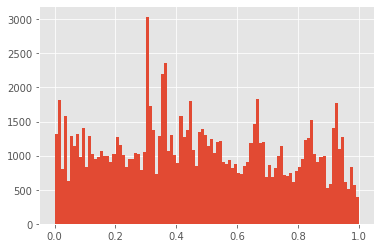

In [386]:
f = features[25]
print(f, len(features))
fig, ax = dw.hist(df[f], bins=100)

In [393]:
f = 'total_outstanding_balance'
encoded_values=None

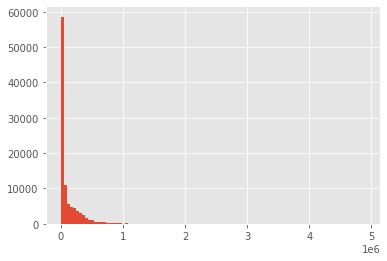

False    100843
True      11756
Name: total_outstanding_balance, dtype: int64

In [394]:
dw.hist(df[f], bins=100)
display(df[f].isna().value_counts())

In [397]:
display(f, dw.quantile(df[f], 0.001), dw.quantile(df[f], 0.97))
print('-'*80)
display(df[f].describe().to_frame())
display(df[f].isna().value_counts())

'total_outstanding_balance'

0.0

579935.0

--------------------------------------------------------------------------------


,total_outstanding_balance
count,1.008430e+05
mean,1.130735e+05
std,1.904964e+05
min,0.000000e+00
25%,4.498000e+03
50%,3.147700e+04
75%,1.493940e+05
max,4.898792e+06


False    100843
True      11756
Name: total_outstanding_balance, dtype: int64

In [392]:
df[f].min(), df[f].max()

(0.0, 4999999.998981366)

In [317]:
# packaging up and aggregate below
encoded_values = None
df['address_risk_score'] = df['address_risk_score'].clip(0,1)

In [318]:
df[f].isna().value_counts()

False    112599
Name: address_risk_score, dtype: int64

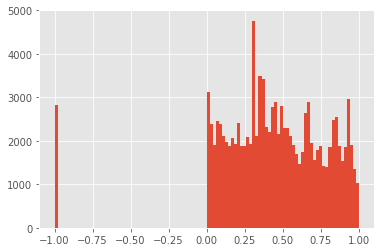

In [319]:
dw.hist(df[f], bins=100)
if encoded_values is not None:
    dw.hist(df[encode_col], bins=100)

### Clean and refine individual features
---
* clip values
* fillna

Features that need additional work, also see modeling notes for more details
* vantage_score
    * values 1 and 4
* nr_transactions_30d_div_nr_past_transactions
    * recalculate using other methods.
* max_deposits_10d_div_mean_account_balance_30d
    * extremely small values
    
    
#### Function moved to src/utils.py

In [371]:
from rdsutils.data_wrangling import DataWrangler

df = modeling_df[features].copy()
dw = DataWrangler()

In [402]:
import pandas as pd
import numpy as np


def preprocess(df):

    f = "vantage_score"
    # encoding
    feature_values, encoded_values = encode_special(
        df, f, pd.Interval(300, 850), False
    )
    df[f] = feature_values
    if encoded_values is not None:
        df[f + "_encoded"] = encoded_values

    f = "bcc7120"
    # encoding
    feature_values, encoded_values = encode_special(df, f, pd.Interval(0, 990), True)
    df[f] = feature_values
    if encoded_values is not None:
        encode_col = f + "_encoded"
        df[encode_col] = encoded_values
    # fillna
    df[f] = df[f].fillna(-1)
    df[encode_col] = df[encode_col].fillna(-1)

    f = "fico_score"
    # encoding
    feature_values, encoded_values = encode_special(df, f, pd.Interval(0, 850), True)
    df[f] = feature_values
    if encoded_values is not None:
        encode_col = f + "_encoded"
        df[encode_col] = encoded_values

    df["first_deposit_amount"] = df["first_deposit_amount"].clip(0, 20000).fillna(-1)
    df["credit_card_loan_amount"] = (
        df["credit_card_loan_amount"].clip(0, 100000).fillna(-1)
    )
    df["plaid_max_avail_bal"] = df["plaid_max_avail_bal"].clip(-100000, 100000)
    df["total_tradelines_open"] = df["total_tradelines_open"].clip(0, 31).fillna(-1)
    df["plaid_days_since_first_link"] = (
        df["plaid_days_since_first_link"].clip(0, 69).fillna(-1)
    )
    df["plaid_min_avail_bal"] = df["plaid_min_avail_bal"].clip(-100000, 100000)
    df["nr_transactions_per_day"] = df["nr_transactions_per_day"].clip(0, 5).fillna(0)
    df["sum_deposits_10d"] = df["sum_deposits_10d"].clip(0, 25000).fillna(0)
    df["quovo_largest_checking_or_savings_balance"] = df[
        "quovo_largest_checking_or_savings_balance"
    ].clip(
        -100000, 100000
    )  # consider encode quovo or plaid
    df["total_outstanding_balance"] = df["total_outstanding_balance"].clip(0, 500000)
    df["rolling_trns_as_pct_of_bal"] = df["rolling_trns_as_pct_of_bal"].clip(-750, 750)
    df["phone_risk_score"] = df["phone_risk_score"].clip(0, 1)
    df["quovo_available_bal"] = df["quovo_available_bal"].clip(-100000, 100000)
    df["email_risk_score"] = df["email_risk_score"].clip(0, 1)
    df["deposits_ratio"] = df["deposits_ratio"].fillna(-1)
    df["fraud_score_1"] = df["fraud_score_1"].clip(0, 1)
    df["mean_deposits_10d_div_mean_deposits"] = (
        df["mean_deposits_10d_div_mean_deposits"].clip(0, 100).fillna(-100)
    )
    df["fraud_score_2"] = df["fraud_score_2"].clip(0, 1)
    df["nr_past_deposits"] = df["nr_past_deposits"].clip(0, 200)
    df["quovo_min_avail_bal"] = df["quovo_min_avail_bal"].clip(-100000, 100000)
    df["address_risk_score"] = df["address_risk_score"].clip(0, 1)

    # check up on vantage_score
    # nr_transactions_30d_div_nr_past_transactions
    # should clip by (0, 1)
    df["nr_transactions_30d_div_nr_past_transactions"] = (
        df["nr_transactions_30d_div_nr_past_transactions"].clip(0, 2).fillna(-1)
    )
    # max_deposits_10d_div_mean_account_balance_30d
    df["max_deposits_10d_div_mean_account_balance_30d"] = (
        df["max_deposits_10d_div_mean_account_balance_30d"].clip(0, 10).fillna(-1)
    )
    return df


def encode_special(df:pd.DataFrame,
                feature: str,
                interval: pd.Interval, 
                encode_special: bool):
    """
    Replace special values (beyond the provided interval inclusive) with NaN.
    If encode_special set to True, int encode them to another column.
    """
    # set up variables
    k = feature
    v = interval
    encode = encode_special
    df = df[feature].copy(deep=True).to_frame()
    cname = k + '_encoded'

    if isinstance(v, pd.Interval):
        is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
    elif isinstance(v, list):
        is_default = df[k].isin(k)
    else:
        raise RuntimeError('Data type {} not supported'.format(str(type(v))))

    if ~is_default.isna().all():
        if encode:
            df.loc[is_default, cname] = is_default * df[k]
        df.loc[is_default, k] = np.nan #set default values to NaN

    feature_col = df[feature]

    encoded_col = None
    if encode:
        encoded_col = df[cname]
    return feature_col, encoded_col

In [399]:
df = preprocess(df)

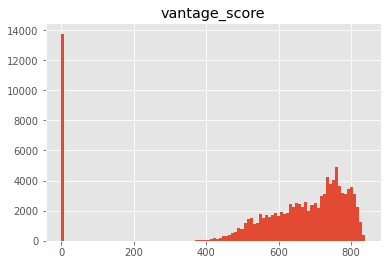

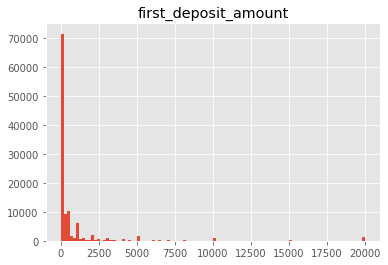

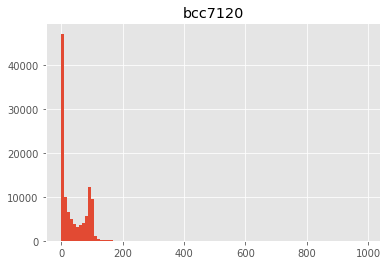

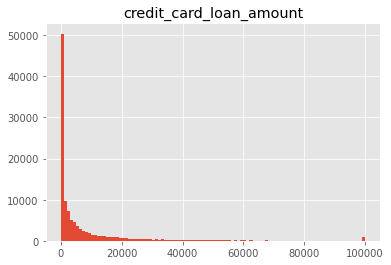

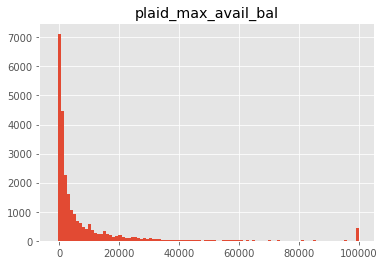

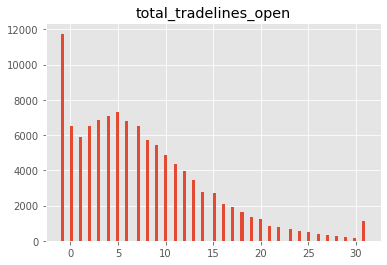

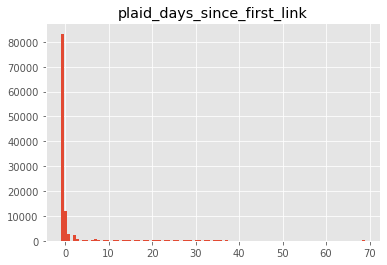

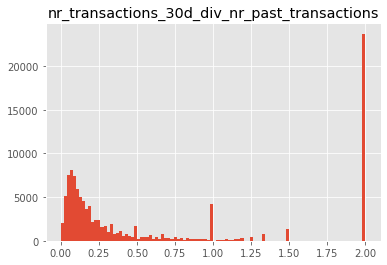

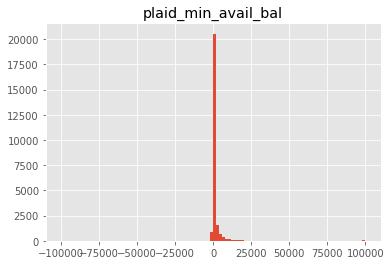

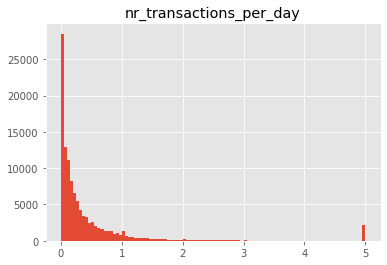

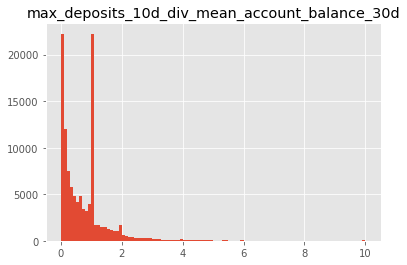

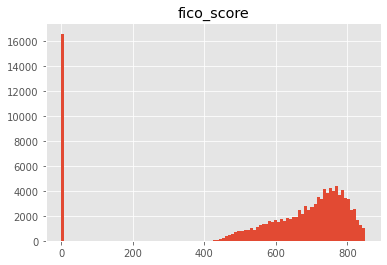

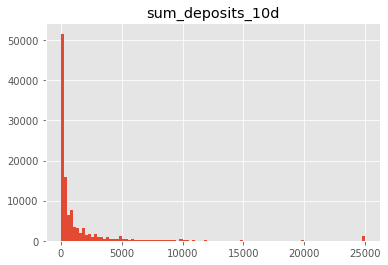

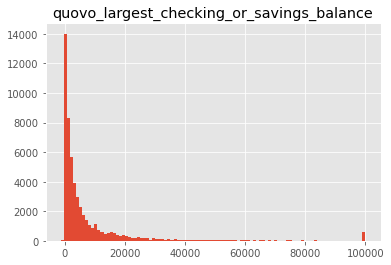

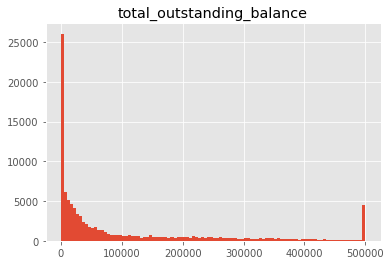

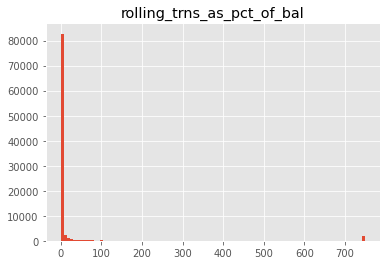

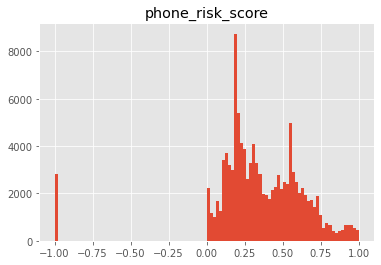

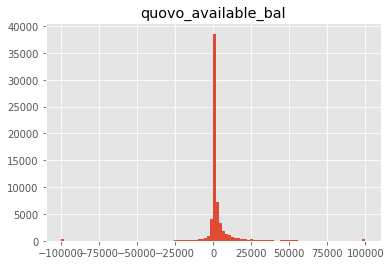

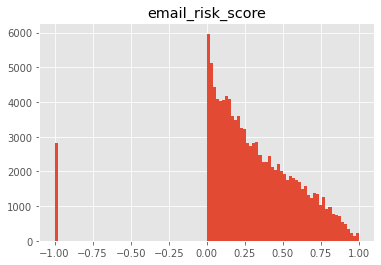

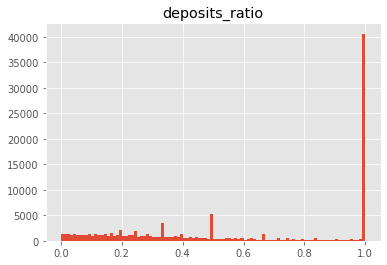

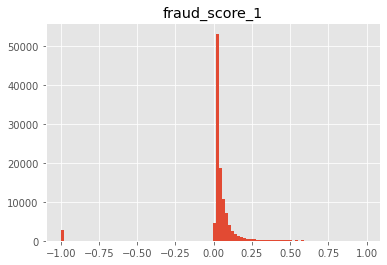

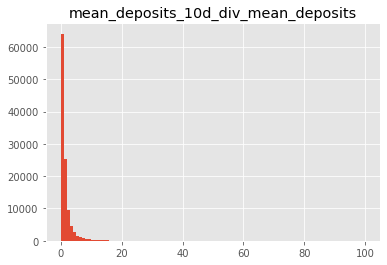

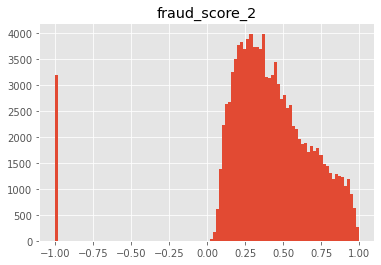

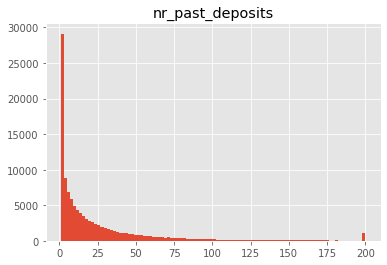

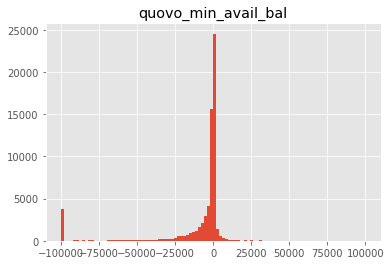

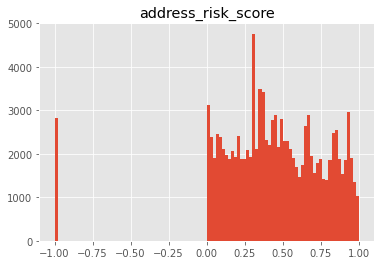

In [400]:
for f in features:
    try:
        df[f].hist(bins=100)
        plt.title(f)
        plt.show()
    except:
        print(f)